# RAG System Evaluation & Metrics
## Comprehensive Testing for Chatbot Performance

**Evaluation Framework:**
1. **Performance Metrics**: Latency, throughput, resource usage
2. **Quality Metrics**: Faithfulness, relevance, completeness
3. **Hallucination Detection**: Identify unsupported claims
4. **Error Tracking**: Failed queries, edge cases, malformed responses
5. **Context Analysis**: Utilization, redundancy, relevance
6. **Comparative Testing**: A/B testing different configurations

**Goal:** Build a robust evaluation suite for production RAG chatbot

In [1]:
# Cell 1: Setup and Imports

import os
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

import warnings
warnings.filterwarnings('ignore')

from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import json

# LangChain
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_ollama import ChatOllama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.callbacks import get_openai_callback

# BM25
from rank_bm25 import BM25Okapi

# Utilities
from tqdm.notebook import tqdm
import time
from datetime import datetime
import re
from difflib import SequenceMatcher

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print(f"Project root: {project_root}")

✅ All imports successful!
Project root: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag


In [2]:
# Cell 2: Configuration

class EvalConfig:
    # Paths
    DATA_DIR = project_root / "data"
    RAW_DIR = DATA_DIR / "raw"
    VECTOR_STORE_DIR = DATA_DIR / "vector_store"
    RESULTS_DIR = DATA_DIR / "eval_results"
    
    # Create results directory
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Model configs
    EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
    LLM_MODEL = "llama3.1:8b"
    LLM_TEMPERATURE = 0.1
    
    # RAG configs
    CHUNK_SIZE = 512
    CHUNK_OVERLAP = 128
    TOP_K = 5
    
    # Evaluation configs
    EVAL_BATCH_SIZE = 10
    TIMEOUT_SECONDS = 30
    
    # Thresholds
    LATENCY_THRESHOLD_MS = 5000  # 5 seconds
    MIN_FAITHFULNESS_SCORE = 0.6
    MIN_RELEVANCE_SCORE = 0.5

config = EvalConfig()

print("📊 Evaluation Configuration:")
print(f"  Results dir: {config.RESULTS_DIR}")
print(f"  Latency threshold: {config.LATENCY_THRESHOLD_MS}ms")
print(f"  Min faithfulness: {config.MIN_FAITHFULNESS_SCORE}")
print(f"  Min relevance: {config.MIN_RELEVANCE_SCORE}")

📊 Evaluation Configuration:
  Results dir: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/eval_results
  Latency threshold: 5000ms
  Min faithfulness: 0.6
  Min relevance: 0.5


In [3]:
# Cell 3: Setup RAG System (from previous notebooks)

def setup_rag_system(pdf_path: str, collection_name: str = "eval_papers"):
    """
    Setup complete RAG system for evaluation
    """
    print("🔧 Setting up RAG system...\n")
    
    # Load PDF
    print("1. Loading PDF...")
    loader = PyMuPDFLoader(pdf_path)
    documents = loader.load()
    print(f"   ✅ Loaded {len(documents)} pages")
    
    # Chunk
    print("\n2. Chunking documents...")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""],
    )
    chunks = text_splitter.split_documents(documents)
    print(f"   ✅ Created {len(chunks)} chunks")
    
    # Embeddings
    print("\n3. Loading embeddings...")
    embeddings = HuggingFaceEmbeddings(
        model_name=config.EMBEDDING_MODEL,
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': True}
    )
    print(f"   ✅ Loaded {config.EMBEDDING_MODEL}")
    
    # Vector store
    print("\n4. Creating vector store...")
    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=str(config.VECTOR_STORE_DIR)
    )
    print(f"   ✅ Vector store ready")
    
    # BM25
    print("\n5. Initializing BM25...")
    tokenized_docs = [doc.page_content.lower().split() for doc in chunks]
    bm25 = BM25Okapi(tokenized_docs)
    print(f"   ✅ BM25 index ready")
    
    # LLM
    print("\n6. Initializing LLM...")
    llm = ChatOllama(
        model=config.LLM_MODEL,
        temperature=config.LLM_TEMPERATURE,
    )
    print(f"   ✅ LLM ready: {config.LLM_MODEL}")
    
    # RAG Chain
    print("\n7. Creating RAG chain...")
    prompt_template = """You are an AI assistant helping researchers understand academic papers.

Use the following context from research papers to answer the question.
If you don't know the answer based on the context, say "I don't have enough information in the provided context to answer this question."

IMPORTANT: Only use information from the context below. Do not add information from your general knowledge.

Context:
{context}

Question: {question}

Answer:"""
    
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["context", "question"]
    )
    
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": config.TOP_K}),
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True
    )
    print(f"   ✅ RAG chain ready")
    
    print("\n" + "="*70)
    print("✅ RAG SYSTEM READY FOR EVALUATION")
    print("="*70)
    
    return {
        'chunks': chunks,
        'vectorstore': vectorstore,
        'bm25': bm25,
        'llm': llm,
        'qa_chain': qa_chain,
        'embeddings': embeddings
    }

print("✅ Setup function ready")

✅ Setup function ready


In [4]:
# Cell 4: Performance Metrics

class PerformanceMetrics:
    """Track latency and performance metrics"""
    
    def __init__(self):
        self.metrics = []
    
    def measure_query(self, qa_chain, query: str):
        """
        Measure performance for a single query
        """
        result = {
            'query': query,
            'timestamp': datetime.now().isoformat(),
            'success': False,
            'error': None
        }
        
        try:
            # Total time
            start_total = time.time()
            
            # Execute query
            response = qa_chain.invoke({"query": query})
            
            end_total = time.time()
            
            # Calculate metrics
            result.update({
                'success': True,
                'total_latency_ms': (end_total - start_total) * 1000,
                'answer': response['result'],
                'answer_length': len(response['result']),
                'num_source_docs': len(response['source_documents']),
                'source_docs': response['source_documents'],
                'meets_latency_threshold': (end_total - start_total) * 1000 < config.LATENCY_THRESHOLD_MS
            })
            
        except Exception as e:
            result['error'] = str(e)
            result['error_type'] = type(e).__name__
        
        self.metrics.append(result)
        return result
    
    def get_summary(self):
        """Get performance summary statistics"""
        if not self.metrics:
            return {}
        
        successful = [m for m in self.metrics if m['success']]
        failed = [m for m in self.metrics if not m['success']]
        
        if not successful:
            return {
                'total_queries': len(self.metrics),
                'success_rate': 0.0,
                'failure_count': len(failed)
            }
        
        latencies = [m['total_latency_ms'] for m in successful]
        
        return {
            'total_queries': len(self.metrics),
            'successful_queries': len(successful),
            'failed_queries': len(failed),
            'success_rate': len(successful) / len(self.metrics),
            'avg_latency_ms': np.mean(latencies),
            'median_latency_ms': np.median(latencies),
            'p95_latency_ms': np.percentile(latencies, 95),
            'p99_latency_ms': np.percentile(latencies, 99),
            'min_latency_ms': np.min(latencies),
            'max_latency_ms': np.max(latencies),
            'std_latency_ms': np.std(latencies),
            'within_threshold_pct': sum(m['meets_latency_threshold'] for m in successful) / len(successful) * 100,
            'avg_answer_length': np.mean([m['answer_length'] for m in successful]),
            'avg_sources_retrieved': np.mean([m['num_source_docs'] for m in successful])
        }
    
    def plot_latency_distribution(self):
        """Plot latency distribution"""
        successful = [m for m in self.metrics if m['success']]
        if not successful:
            print("No successful queries to plot")
            return
        
        latencies = [m['total_latency_ms'] for m in successful]
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        axes[0].hist(latencies, bins=20, edgecolor='black', alpha=0.7)
        axes[0].axvline(np.mean(latencies), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(latencies):.0f}ms')
        axes[0].axvline(config.LATENCY_THRESHOLD_MS, color='orange', linestyle='--', 
                       label=f'Threshold: {config.LATENCY_THRESHOLD_MS}ms')
        axes[0].set_xlabel('Latency (ms)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Latency Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        axes[1].boxplot(latencies, vert=True)
        axes[1].axhline(config.LATENCY_THRESHOLD_MS, color='orange', linestyle='--', 
                       label=f'Threshold: {config.LATENCY_THRESHOLD_MS}ms')
        axes[1].set_ylabel('Latency (ms)')
        axes[1].set_title('Latency Box Plot')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("✅ Performance metrics class ready")

✅ Performance metrics class ready


In [5]:
# Cell 5: Quality Metrics (Faithfulness, Relevance, Hallucination)

class QualityMetrics:
    """Evaluate answer quality and detect hallucinations"""
    
    @staticmethod
    def calculate_faithfulness(answer: str, context_docs: List) -> Dict:
        """
        Measure if answer is grounded in context (hallucination detection)
        """
        if not context_docs or not answer:
            return {'score': 0.0, 'method': 'empty_input'}
        
        # Combine all context
        context_text = " ".join([doc.page_content for doc in context_docs]).lower()
        answer_lower = answer.lower()
        
        # Check if answer indicates "don't know"
        uncertain_phrases = [
            "don't have enough information",
            "cannot answer",
            "not enough context",
            "i don't know",
            "unclear from the context"
        ]
        
        is_uncertain = any(phrase in answer_lower for phrase in uncertain_phrases)
        
        # Split answer into sentences
        sentences = [s.strip() for s in re.split(r'[.!?]+', answer) if s.strip()]
        
        if not sentences:
            return {'score': 0.0, 'method': 'no_sentences', 'is_uncertain': is_uncertain}
        
        # Check each sentence for grounding
        grounded_sentences = 0
        sentence_details = []
        
        for sentence in sentences:
            sentence_lower = sentence.lower()
            words = sentence_lower.split()
            
            # Skip very short sentences
            if len(words) < 3:
                continue
            
            # Check for n-gram overlap (3-5 word phrases)
            max_overlap = 0
            for n in [3, 4, 5]:
                if len(words) >= n:
                    for i in range(len(words) - n + 1):
                        ngram = ' '.join(words[i:i+n])
                        if ngram in context_text:
                            max_overlap = max(max_overlap, n)
                            grounded_sentences += 1
                            sentence_details.append({
                                'sentence': sentence,
                                'grounded': True,
                                'max_ngram': n
                            })
                            break
                if max_overlap > 0:
                    break
            
            if max_overlap == 0:
                # Check semantic similarity (simple word overlap)
                answer_words = set(words)
                context_words = set(context_text.split())
                overlap = len(answer_words.intersection(context_words)) / len(answer_words)
                
                if overlap > 0.5:  # More than 50% word overlap
                    grounded_sentences += 1
                    sentence_details.append({
                        'sentence': sentence,
                        'grounded': True,
                        'word_overlap': overlap
                    })
                else:
                    sentence_details.append({
                        'sentence': sentence,
                        'grounded': False,
                        'word_overlap': overlap
                    })
        
        faithfulness_score = grounded_sentences / len(sentences) if sentences else 0.0
        
        return {
            'score': faithfulness_score,
            'total_sentences': len(sentences),
            'grounded_sentences': grounded_sentences,
            'ungrounded_sentences': len(sentences) - grounded_sentences,
            'is_uncertain': is_uncertain,
            'sentence_details': sentence_details,
            'likely_hallucination': faithfulness_score < config.MIN_FAITHFULNESS_SCORE and not is_uncertain
        }
    
    @staticmethod
    def calculate_answer_relevance(answer: str, query: str) -> Dict:
        """
        Measure if answer addresses the query
        """
        if not answer or not query:
            return {'score': 0.0, 'method': 'empty_input'}
        
        answer_lower = answer.lower()
        query_lower = query.lower()
        
        # Extract key terms from query (exclude stop words)
        stop_words = {'what', 'is', 'are', 'the', 'a', 'an', 'how', 'why', 'when', 'where', 
                     'does', 'do', 'did', 'can', 'could', 'would', 'should', 'in', 'on', 'at',
                     'to', 'for', 'of', 'and', 'or', 'but', 'this', 'that', 'these', 'those'}
        
        query_terms = [w for w in query_lower.split() if w not in stop_words and len(w) > 2]
        
        if not query_terms:
            return {'score': 0.5, 'method': 'no_key_terms'}
        
        # Check term presence in answer
        terms_in_answer = sum(1 for term in query_terms if term in answer_lower)
        term_coverage = terms_in_answer / len(query_terms)
        
        # Check if answer is "don't know" type
        is_uncertain = any(phrase in answer_lower for phrase in [
            "don't have enough information", "cannot answer", "not enough context"
        ])
        
        # Calculate relevance score
        relevance_score = term_coverage
        
        return {
            'score': relevance_score,
            'query_terms': query_terms,
            'terms_found': terms_in_answer,
            'term_coverage': term_coverage,
            'is_uncertain': is_uncertain,
            'is_relevant': relevance_score >= config.MIN_RELEVANCE_SCORE or is_uncertain
        }
    
    @staticmethod
    def calculate_context_relevance(query: str, context_docs: List) -> Dict:
        """
        Measure if retrieved context is relevant to query
        """
        if not context_docs or not query:
            return {'score': 0.0, 'method': 'empty_input'}
        
        query_lower = query.lower()
        stop_words = {'what', 'is', 'are', 'the', 'a', 'an', 'how', 'why', 'when', 'where'}
        query_terms = [w for w in query_lower.split() if w not in stop_words and len(w) > 2]
        
        if not query_terms:
            return {'score': 0.5, 'method': 'no_key_terms'}
        
        # Check each document
        doc_scores = []
        for doc in context_docs:
            doc_text = doc.page_content.lower()
            terms_found = sum(1 for term in query_terms if term in doc_text)
            doc_scores.append(terms_found / len(query_terms))
        
        avg_relevance = np.mean(doc_scores) if doc_scores else 0.0
        
        return {
            'score': avg_relevance,
            'avg_doc_relevance': avg_relevance,
            'relevant_docs': sum(1 for s in doc_scores if s > 0.3),
            'total_docs': len(context_docs),
            'doc_scores': doc_scores
        }
    
    @staticmethod
    def detect_contradictions(answer: str, context_docs: List) -> Dict:
        """
        Simple contradiction detection
        """
        # Check for negation patterns that might indicate contradictions
        negation_patterns = [
            (r'\bnot\b', r'\bis\b'),
            (r'\bno\b', r'\byes\b'),
            (r'\bnever\b', r'\balways\b'),
            (r'\bcannot\b', r'\bcan\b')
        ]
        
        answer_lower = answer.lower()
        context_text = " ".join([doc.page_content.lower() for doc in context_docs])
        
        potential_contradictions = []
        for neg, pos in negation_patterns:
            if re.search(neg, answer_lower) and re.search(pos, context_text):
                potential_contradictions.append((neg, pos))
        
        return {
            'has_potential_contradiction': len(potential_contradictions) > 0,
            'contradiction_count': len(potential_contradictions),
            'patterns': potential_contradictions
        }

print("✅ Quality metrics class ready")

✅ Quality metrics class ready


In [6]:
# Cell 6: Error Tracking and Analysis

class ErrorTracker:
    """Track and categorize errors"""
    
    def __init__(self):
        self.errors = []
    
    def log_error(self, query: str, error: Exception, context: Dict = None):
        """Log an error with context"""
        error_entry = {
            'timestamp': datetime.now().isoformat(),
            'query': query,
            'error_type': type(error).__name__,
            'error_message': str(error),
            'context': context or {}
        }
        self.errors.append(error_entry)
    
    def get_error_summary(self) -> Dict:
        """Get summary of errors"""
        if not self.errors:
            return {'total_errors': 0}
        
        error_types = Counter([e['error_type'] for e in self.errors])
        
        return {
            'total_errors': len(self.errors),
            'error_types': dict(error_types),
            'most_common_error': error_types.most_common(1)[0] if error_types else None,
            'unique_error_types': len(error_types)
        }
    
    def plot_errors(self):
        """Visualize error distribution"""
        if not self.errors:
            print("No errors to plot")
            return
        
        error_types = Counter([e['error_type'] for e in self.errors])
        
        plt.figure(figsize=(10, 6))
        plt.bar(error_types.keys(), error_types.values())
        plt.xlabel('Error Type')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

print("✅ Error tracker ready")

✅ Error tracker ready


In [7]:
# Cell 7: Comprehensive RAG Evaluator

class RAGEvaluator:
    """Comprehensive evaluation suite for RAG system"""
    
    def __init__(self, rag_system: Dict):
        self.rag_system = rag_system
        self.performance = PerformanceMetrics()
        self.quality = QualityMetrics()
        self.errors = ErrorTracker()
        self.results = []
    
    def evaluate_query(self, query: str, expected_answer: str = None) -> Dict:
        """
        Comprehensive evaluation of a single query
        """
        print(f"\n📝 Evaluating: {query[:80]}...")
        
        # Performance measurement
        perf_result = self.performance.measure_query(self.rag_system['qa_chain'], query)
        
        if not perf_result['success']:
            print(f"   ❌ Query failed: {perf_result['error']}")
            self.errors.log_error(query, Exception(perf_result['error']))
            return perf_result
        
        # Quality metrics
        answer = perf_result['answer']
        source_docs = perf_result['source_docs']
        
        faithfulness = self.quality.calculate_faithfulness(answer, source_docs)
        answer_relevance = self.quality.calculate_answer_relevance(answer, query)
        context_relevance = self.quality.calculate_context_relevance(query, source_docs)
        contradictions = self.quality.detect_contradictions(answer, source_docs)
        
        # Combine all metrics
        eval_result = {
            **perf_result,
            'faithfulness': faithfulness,
            'answer_relevance': answer_relevance,
            'context_relevance': context_relevance,
            'contradictions': contradictions,
            'quality_score': np.mean([
                faithfulness['score'],
                answer_relevance['score'],
                context_relevance['score']
            ])
        }
        
        # Print summary
        print(f"   ⏱️  Latency: {perf_result['total_latency_ms']:.0f}ms")
        print(f"   📊 Quality Score: {eval_result['quality_score']:.2f}")
        print(f"   🎯 Faithfulness: {faithfulness['score']:.2f}")
        print(f"   🔍 Answer Relevance: {answer_relevance['score']:.2f}")
        print(f"   📚 Context Relevance: {context_relevance['score']:.2f}")
        
        if faithfulness.get('likely_hallucination'):
            print("   ⚠️  WARNING: Possible hallucination detected!")
        
        if contradictions.get('has_potential_contradiction'):
            print("   ⚠️  WARNING: Potential contradiction detected!")
        
        self.results.append(eval_result)
        return eval_result
    
    def evaluate_batch(self, queries: List[str], show_progress: bool = True):
        """
        Evaluate multiple queries
        """
        print("="*80)
        print(f"BATCH EVALUATION: {len(queries)} queries")
        print("="*80)
        
        iterator = tqdm(queries) if show_progress else queries
        
        for query in iterator:
            self.evaluate_query(query)
        
        print("\n" + "="*80)
        print("✅ BATCH EVALUATION COMPLETE")
        print("="*80)
    
    def get_summary_report(self) -> Dict:
        """
        Get comprehensive summary of all evaluations
        """
        perf_summary = self.performance.get_summary()
        error_summary = self.errors.get_error_summary()
        
        successful_results = [r for r in self.results if r['success']]
        
        if successful_results:
            quality_summary = {
                'avg_quality_score': np.mean([r['quality_score'] for r in successful_results]),
                'avg_faithfulness': np.mean([r['faithfulness']['score'] for r in successful_results]),
                'avg_answer_relevance': np.mean([r['answer_relevance']['score'] for r in successful_results]),
                'avg_context_relevance': np.mean([r['context_relevance']['score'] for r in successful_results]),
                'hallucination_count': sum(1 for r in successful_results 
                                          if r['faithfulness'].get('likely_hallucination', False)),
                'contradiction_count': sum(1 for r in successful_results 
                                          if r['contradictions'].get('has_potential_contradiction', False)),
                'below_faithfulness_threshold': sum(1 for r in successful_results 
                                                   if r['faithfulness']['score'] < config.MIN_FAITHFULNESS_SCORE),
                'below_relevance_threshold': sum(1 for r in successful_results 
                                                if r['answer_relevance']['score'] < config.MIN_RELEVANCE_SCORE)
            }
        else:
            quality_summary = {}
        
        return {
            'performance': perf_summary,
            'quality': quality_summary,
            'errors': error_summary,
            'total_evaluations': len(self.results)
        }
    
    def print_report(self):
        """Print formatted evaluation report"""
        report = self.get_summary_report()
        
        print("\n" + "="*80)
        print("COMPREHENSIVE EVALUATION REPORT")
        print("="*80)
        
        print("\n📊 PERFORMANCE METRICS:")
        print("-" * 80)
        for key, value in report['performance'].items():
            if isinstance(value, float):
                print(f"  {key}: {value:.2f}")
            else:
                print(f"  {key}: {value}")
        
        if report['quality']:
            print("\n🎯 QUALITY METRICS:")
            print("-" * 80)
            for key, value in report['quality'].items():
                if isinstance(value, float):
                    print(f"  {key}: {value:.3f}")
                else:
                    print(f"  {key}: {value}")
        
        print("\n❌ ERROR SUMMARY:")
        print("-" * 80)
        for key, value in report['errors'].items():
            print(f"  {key}: {value}")
        
        # Warnings
        print("\n⚠️  WARNINGS:")
        print("-" * 80)
        if report['quality'].get('hallucination_count', 0) > 0:
            print(f"  🚨 {report['quality']['hallucination_count']} potential hallucinations detected!")
        if report['quality'].get('contradiction_count', 0) > 0:
            print(f"  🚨 {report['quality']['contradiction_count']} potential contradictions detected!")
        if report['performance'].get('failed_queries', 0) > 0:
            print(f"  🚨 {report['performance']['failed_queries']} queries failed!")
        if not any([report['quality'].get('hallucination_count', 0) > 0,
                   report['quality'].get('contradiction_count', 0) > 0,
                   report['performance'].get('failed_queries', 0) > 0]):
            print("  ✅ No warnings")
        
        print("\n" + "="*80)
    
    def visualize_results(self):
        """Visualize evaluation results"""
        if not self.results:
            print("No results to visualize")
            return
        
        # Create visualizations
        self.performance.plot_latency_distribution()
        
        # Quality metrics
        successful_results = [r for r in self.results if r['success']]
        if successful_results:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # Faithfulness distribution
            faithfulness_scores = [r['faithfulness']['score'] for r in successful_results]
            axes[0, 0].hist(faithfulness_scores, bins=20, edgecolor='black', alpha=0.7)
            axes[0, 0].axvline(config.MIN_FAITHFULNESS_SCORE, color='red', linestyle='--',
                             label=f'Threshold: {config.MIN_FAITHFULNESS_SCORE}')
            axes[0, 0].set_xlabel('Faithfulness Score')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].set_title('Faithfulness Score Distribution')
            axes[0, 0].legend()
            
            # Answer relevance distribution
            relevance_scores = [r['answer_relevance']['score'] for r in successful_results]
            axes[0, 1].hist(relevance_scores, bins=20, edgecolor='black', alpha=0.7, color='green')
            axes[0, 1].axvline(config.MIN_RELEVANCE_SCORE, color='red', linestyle='--',
                             label=f'Threshold: {config.MIN_RELEVANCE_SCORE}')
            axes[0, 1].set_xlabel('Answer Relevance Score')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Answer Relevance Distribution')
            axes[0, 1].legend()
            
            # Quality score vs latency
            quality_scores = [r['quality_score'] for r in successful_results]
            latencies = [r['total_latency_ms'] for r in successful_results]
            axes[1, 0].scatter(latencies, quality_scores, alpha=0.6)
            axes[1, 0].set_xlabel('Latency (ms)')
            axes[1, 0].set_ylabel('Quality Score')
            axes[1, 0].set_title('Quality vs Latency')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Metric comparison
            metrics_df = pd.DataFrame({
                'Faithfulness': faithfulness_scores,
                'Answer Relevance': relevance_scores,
                'Context Relevance': [r['context_relevance']['score'] for r in successful_results]
            })
            metrics_df.boxplot(ax=axes[1, 1])
            axes[1, 1].set_ylabel('Score')
            axes[1, 1].set_title('Quality Metrics Comparison')
            axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    def save_results(self, filename: str = None):
        """Save evaluation results to JSON"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"rag_eval_{timestamp}.json"
        
        filepath = config.RESULTS_DIR / filename
        
        # Prepare results (remove non-serializable objects)
        serializable_results = []
        for r in self.results:
            r_copy = r.copy()
            if 'source_docs' in r_copy:
                r_copy['source_docs'] = [{
                    'content': doc.page_content[:200],
                    'metadata': doc.metadata
                } for doc in r_copy['source_docs']]
            serializable_results.append(r_copy)
        
        output = {
            'timestamp': datetime.now().isoformat(),
            'config': {
                'embedding_model': config.EMBEDDING_MODEL,
                'llm_model': config.LLM_MODEL,
                'chunk_size': config.CHUNK_SIZE,
                'top_k': config.TOP_K
            },
            'summary': self.get_summary_report(),
            'results': serializable_results
        }
        
        with open(filepath, 'w') as f:
            json.dump(output, f, indent=2)
        
        print(f"\n💾 Results saved to: {filepath}")
        return filepath

print("✅ RAG Evaluator ready")

✅ RAG Evaluator ready


In [8]:
# Cell 8: Create Test Dataset

# Test queries for BERT paper
test_queries = [
    # Factual questions
    "What does BERT stand for?",
    "What are the two pre-training tasks used in BERT?",
    "What is the difference between BERT-base and BERT-large?",
    "Which datasets were used for pre-training BERT?",
    "What is the maximum sequence length used in BERT?",
    
    # Conceptual questions
    "How does BERT achieve bidirectional context?",
    "What is masked language modeling?",
    "Why is BERT better than previous models like ELMo?",
    "What is the next sentence prediction task?",
    
    # Results questions
    "What were BERT's results on the GLUE benchmark?",
    "How did BERT perform on SQuAD?",
    
    # Edge cases - should trigger "don't know" responses
    "What programming language was used to implement BERT?",
    "Who funded the BERT research?",
    "What is the carbon footprint of training BERT?",
    
    # Complex questions
    "What are the key innovations that make BERT different from GPT?",
    "How does fine-tuning work in BERT?",
]

print(f"📋 Created test dataset with {len(test_queries)} queries")
print("\nQuery categories:")
print("  • Factual: 5 queries")
print("  • Conceptual: 4 queries")
print("  • Results: 2 queries")
print("  • Edge cases: 3 queries")
print("  • Complex: 2 queries")

📋 Created test dataset with 16 queries

Query categories:
  • Factual: 5 queries
  • Conceptual: 4 queries
  • Results: 2 queries
  • Edge cases: 3 queries
  • Complex: 2 queries


In [9]:
# Cell 9: Initialize System and Run Evaluation

# Setup RAG system
pdf_path = str(config.RAW_DIR / "bert.pdf")
rag_system = setup_rag_system(pdf_path, collection_name="eval_bert")

# Create evaluator
print("\n🔬 Initializing evaluator...")
evaluator = RAGEvaluator(rag_system)
print("✅ Evaluator ready\n")

# Run evaluation
evaluator.evaluate_batch(test_queries, show_progress=True)

🔧 Setting up RAG system...

1. Loading PDF...
   ✅ Loaded 16 pages

2. Chunking documents...
   ✅ Created 169 chunks

3. Loading embeddings...


/var/folders/9c/3n849rn554l15tgrg12vm59m0000gn/T/ipykernel_64243/304218883.py:27: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


   ✅ Loaded sentence-transformers/all-MiniLM-L6-v2

4. Creating vector store...


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


   ✅ Vector store ready

5. Initializing BM25...
   ✅ BM25 index ready

6. Initializing LLM...
   ✅ LLM ready: llama3.1:8b

7. Creating RAG chain...
   ✅ RAG chain ready

✅ RAG SYSTEM READY FOR EVALUATION

🔬 Initializing evaluator...
✅ Evaluator ready

BATCH EVALUATION: 16 queries


  0%|          | 0/16 [00:00<?, ?it/s]

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given



📝 Evaluating: What does BERT stand for?...
   ⏱️  Latency: 14627ms
   📊 Quality Score: 0.29
   🎯 Faithfulness: 0.00
   🔍 Answer Relevance: 0.67
   📚 Context Relevance: 0.20

📝 Evaluating: What are the two pre-training tasks used in BERT?...
   ⏱️  Latency: 6332ms
   📊 Quality Score: 0.42
   🎯 Faithfulness: 0.50
   🔍 Answer Relevance: 0.40
   📚 Context Relevance: 0.36
   ⚠️  WARNING: Potential contradiction detected!

📝 Evaluating: What is the difference between BERT-base and BERT-large?...
   ⏱️  Latency: 12607ms
   📊 Quality Score: 0.39
   🎯 Faithfulness: 0.22
   🔍 Answer Relevance: 0.75
   📚 Context Relevance: 0.20
   ⚠️  WARNING: Possible hallucination detected!

📝 Evaluating: Which datasets were used for pre-training BERT?...
   ⏱️  Latency: 8518ms
   📊 Quality Score: 0.66
   🎯 Faithfulness: 0.80
   🔍 Answer Relevance: 0.83
   📚 Context Relevance: 0.34
   ⚠️  WARNING: Potential contradiction detected!

📝 Evaluating: What is the maximum sequence length used in BERT?...
   ⏱️  Laten


COMPREHENSIVE EVALUATION REPORT

📊 PERFORMANCE METRICS:
--------------------------------------------------------------------------------
  total_queries: 16
  successful_queries: 16
  failed_queries: 0
  success_rate: 1.00
  avg_latency_ms: 9209.86
  median_latency_ms: 7127.97
  p95_latency_ms: 15352.00
  p99_latency_ms: 17091.38
  min_latency_ms: 5126.88
  max_latency_ms: 17526.22
  std_latency_ms: 3788.40
  within_threshold_pct: 0.00
  avg_answer_length: 403.56
  avg_sources_retrieved: 5.00

🎯 QUALITY METRICS:
--------------------------------------------------------------------------------
  avg_quality_score: 0.447
  avg_faithfulness: 0.466
  avg_answer_relevance: 0.611
  avg_context_relevance: 0.263
  hallucination_count: 4
  contradiction_count: 8
  below_faithfulness_threshold: 11
  below_relevance_threshold: 5

❌ ERROR SUMMARY:
--------------------------------------------------------------------------------
  total_errors: 0

⚠️  WARNINGS:
--------------------------------------

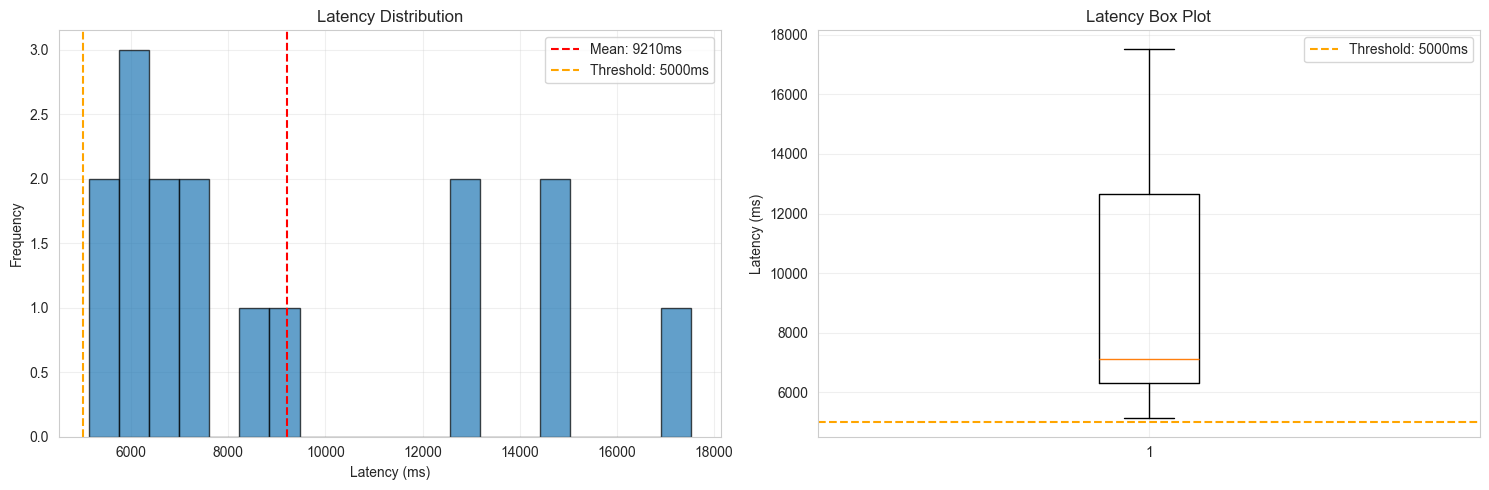

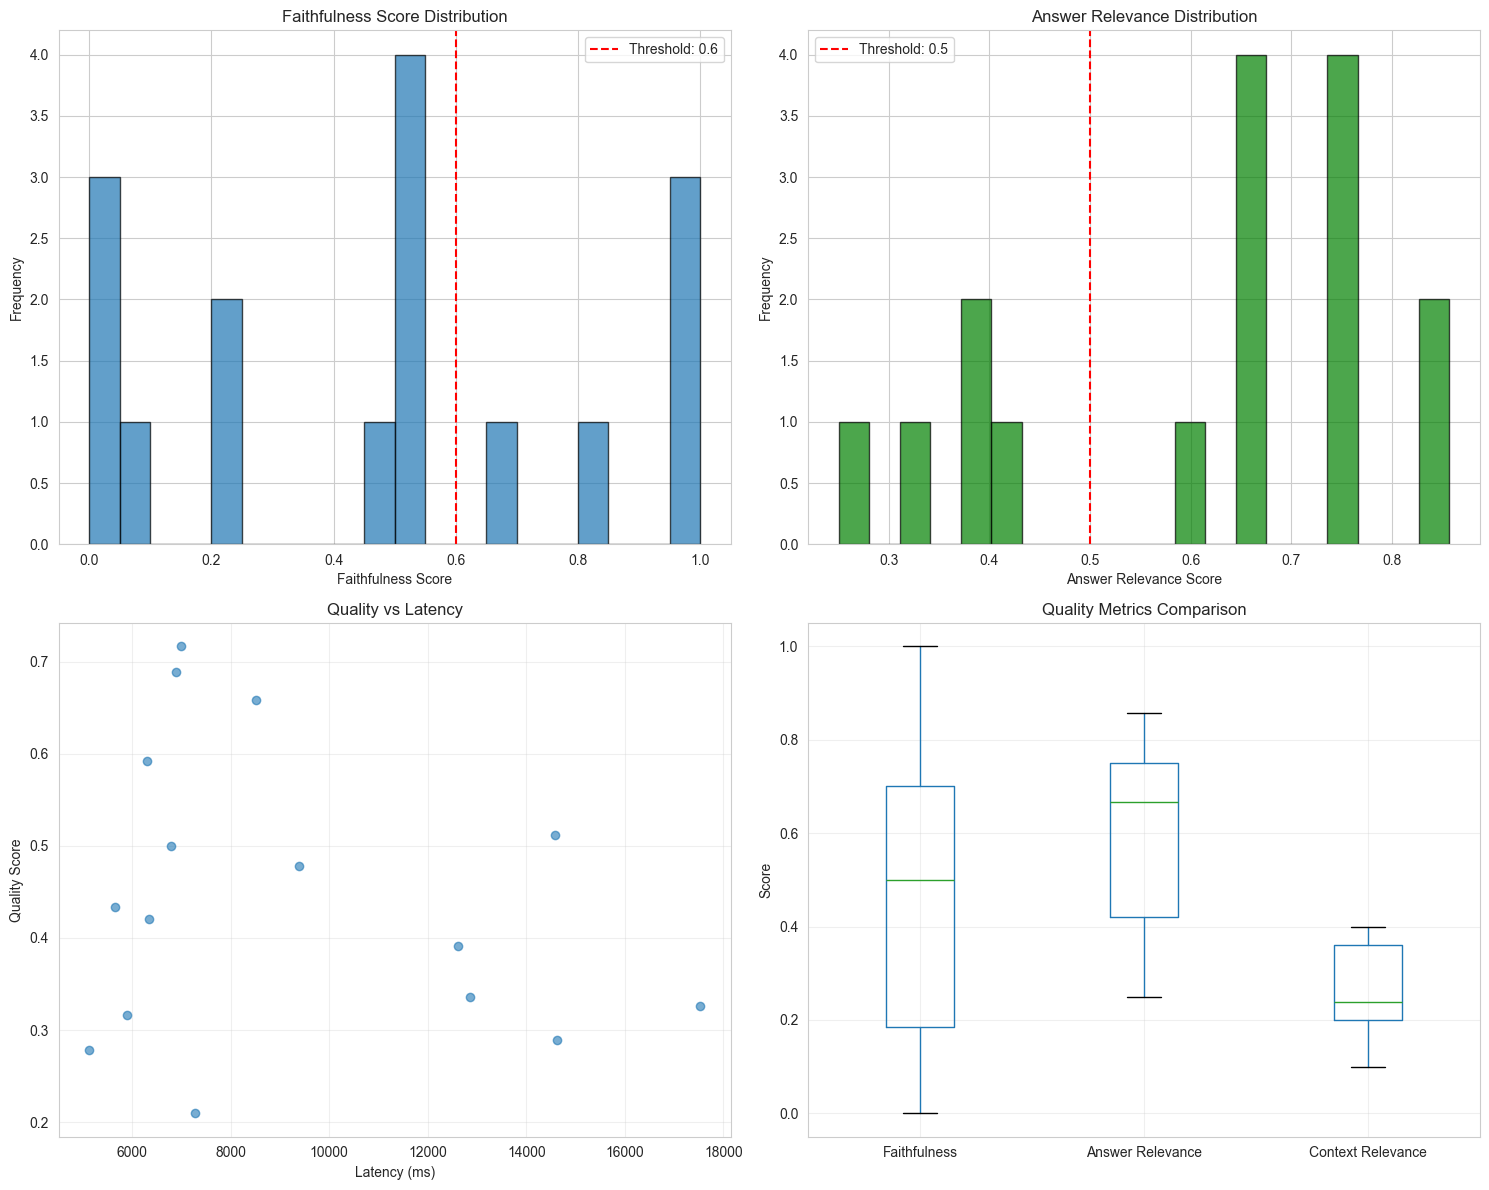

In [10]:
# Cell 10: Display Results

# Print comprehensive report
evaluator.print_report()

# Visualize results
print("\n📊 Generating visualizations...\n")
evaluator.visualize_results()

In [11]:
# Cell 11: Detailed Analysis - Hallucination Cases

print("="*80)
print("HALLUCINATION ANALYSIS")
print("="*80)

hallucination_cases = [
    r for r in evaluator.results 
    if r['success'] and r['faithfulness'].get('likely_hallucination', False)
]

if hallucination_cases:
    print(f"\n🚨 Found {len(hallucination_cases)} potential hallucination(s)\n")
    
    for i, case in enumerate(hallucination_cases, 1):
        print(f"Case {i}:")
        print("-" * 80)
        print(f"Query: {case['query']}")
        print(f"\nAnswer: {case['answer'][:300]}...")
        print(f"\nFaithfulness Score: {case['faithfulness']['score']:.2f}")
        print(f"Grounded Sentences: {case['faithfulness']['grounded_sentences']}/{case['faithfulness']['total_sentences']}")
        print("\nUngrounded sentences:")
        for detail in case['faithfulness']['sentence_details']:
            if not detail.get('grounded', True):
                print(f"  • {detail['sentence']}")
        print("\n" + "="*80 + "\n")
else:
    print("\n✅ No hallucinations detected!")

# Low quality answers
print("\n" + "="*80)
print("LOW QUALITY ANSWERS")
print("="*80)

low_quality = [
    r for r in evaluator.results
    if r['success'] and r['quality_score'] < 0.5
]

if low_quality:
    print(f"\n⚠️  Found {len(low_quality)} low quality answer(s)\n")
    
    for i, case in enumerate(low_quality, 1):
        print(f"Case {i}:")
        print("-" * 80)
        print(f"Query: {case['query']}")
        print(f"Quality Score: {case['quality_score']:.2f}")
        print(f"Answer: {case['answer'][:200]}...")
        print("\n" + "="*80 + "\n")
else:
    print("\n✅ All answers meet quality threshold!")

HALLUCINATION ANALYSIS

🚨 Found 4 potential hallucination(s)

Case 1:
--------------------------------------------------------------------------------
Query: What is the difference between BERT-base and BERT-large?

Answer: According to the context, the main differences between BERT-BASE and BERT-LARGE are:

1. Model size: BERT-LARGE has 340M parameters, while BERT-BASE has 110M parameters.
2. Number of layers (L): BERT-LARGE has L=24, while BERT-BASE has L=12.
3. Hidden state size (H): BERT-LARGE has H=1024, while BER...

Faithfulness Score: 0.22
Grounded Sentences: 2/9

Ungrounded sentences:
  • According to the context, the main differences between BERT-BASE and BERT-LARGE are:

1
  • Number of layers (L): BERT-LARGE has L=24, while BERT-BASE has L=12
  • Hidden state size (H): BERT-LARGE has H=1024, while BERT-BASE has H=768
  • These differences contribute to the improved performance of BERT-LARGE compared to BERT-BASE on various tasks, as mentioned in the paper


Case 2:
--------

In [12]:
# Cell 12: A/B Testing Different Configurations

def ab_test_configs(queries: List[str], configs_to_test: List[Dict]):
    """
    Test different RAG configurations
    """
    results = {}
    
    for config_name, config_params in configs_to_test:
        print(f"\n{'='*80}")
        print(f"Testing Configuration: {config_name}")
        print(f"Parameters: {config_params}")
        print("="*80)
        
        # Update config
        for param, value in config_params.items():
            setattr(config, param, value)
        
        # Setup system with new config
        rag_system = setup_rag_system(pdf_path, collection_name=f"ab_test_{config_name}")
        
        # Evaluate
        evaluator = RAGEvaluator(rag_system)
        evaluator.evaluate_batch(queries[:5], show_progress=False)  # Test on subset
        
        # Store results
        results[config_name] = evaluator.get_summary_report()
    
    return results

# Example: Test different TOP_K values
configs_to_test = [
    ('baseline', {'TOP_K': 5, 'CHUNK_SIZE': 512}),
    ('more_context', {'TOP_K': 10, 'CHUNK_SIZE': 512}),
    ('larger_chunks', {'TOP_K': 5, 'CHUNK_SIZE': 1024}),
]

print("🔬 Running A/B tests...")
print("Testing configurations:")
for name, params in configs_to_test:
    print(f"  • {name}: {params}")

# Uncomment to run
# ab_results = ab_test_configs(test_queries, configs_to_test)
print("\n⏭️  A/B testing setup ready (uncomment to run)")

🔬 Running A/B tests...
Testing configurations:
  • baseline: {'TOP_K': 5, 'CHUNK_SIZE': 512}
  • more_context: {'TOP_K': 10, 'CHUNK_SIZE': 512}
  • larger_chunks: {'TOP_K': 5, 'CHUNK_SIZE': 1024}

⏭️  A/B testing setup ready (uncomment to run)


In [13]:
# Cell 13: Save Results

# Save evaluation results
saved_path = evaluator.save_results()

print("\n📊 Evaluation Summary:")
print(f"  Total queries evaluated: {len(evaluator.results)}")
print(f"  Results saved to: {saved_path}")
print("\n✅ Evaluation complete!")


💾 Results saved to: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/eval_results/rag_eval_20251114_180839.json

📊 Evaluation Summary:
  Total queries evaluated: 16
  Results saved to: /Users/edsonflores/Documents/vsc/Freelance/dev-chatbot-rag/data/eval_results/rag_eval_20251114_180839.json

✅ Evaluation complete!


In [14]:
# Cell 14: Export Results as DataFrame for Further Analysis

def results_to_dataframe(evaluator: RAGEvaluator) -> pd.DataFrame:
    """
    Convert evaluation results to pandas DataFrame
    """
    data = []
    
    for r in evaluator.results:
        if r['success']:
            data.append({
                'query': r['query'],
                'latency_ms': r['total_latency_ms'],
                'answer_length': r['answer_length'],
                'num_sources': r['num_source_docs'],
                'quality_score': r['quality_score'],
                'faithfulness': r['faithfulness']['score'],
                'answer_relevance': r['answer_relevance']['score'],
                'context_relevance': r['context_relevance']['score'],
                'likely_hallucination': r['faithfulness'].get('likely_hallucination', False),
                'has_contradiction': r['contradictions'].get('has_potential_contradiction', False),
                'is_uncertain': r['faithfulness'].get('is_uncertain', False)
            })
    
    return pd.DataFrame(data)

# Create DataFrame
df_results = results_to_dataframe(evaluator)

print("📊 Results DataFrame:")
print(df_results.head(10))

# Summary statistics
print("\n📈 Summary Statistics:")
print(df_results[['latency_ms', 'quality_score', 'faithfulness', 'answer_relevance']].describe())

# Save to CSV
csv_path = config.RESULTS_DIR / f"eval_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df_results.to_csv(csv_path, index=False)
print(f"\n💾 DataFrame saved to: {csv_path}")

📊 Results DataFrame:
                                               query    latency_ms  \
0                          What does BERT stand for?  14627.264977   
1  What are the two pre-training tasks used in BERT?   6332.308054   
2  What is the difference between BERT-base and B...  12607.395887   
3    Which datasets were used for pre-training BERT?   8518.009186   
4  What is the maximum sequence length used in BERT?   5650.438309   
5       How does BERT achieve bidirectional context?   6302.164078   
6                  What is masked language modeling?   6892.834663   
7  Why is BERT better than previous models like E...   7268.600941   
8         What is the next sentence prediction task?   6987.334013   
9    What were BERT's results on the GLUE benchmark?  17526.220083   

   answer_length  num_sources  quality_score  faithfulness  answer_relevance  \
0            324            5       0.288889      0.000000          0.666667   
1            277            5       0.420000    

## Summary

This notebook provides a comprehensive evaluation framework for RAG systems with:

### ✅ Implemented Metrics

**Performance:**
- Latency (total, avg, p95, p99)
- Success rate
- Throughput
- Error tracking

**Quality:**
- **Faithfulness**: Answer grounded in context (hallucination detection)
- **Answer Relevance**: Answer addresses the query
- **Context Relevance**: Retrieved chunks are relevant
- **Contradiction Detection**: Identify conflicting information

**Analysis:**
- Hallucination identification
- Low quality answer detection
- Error categorization
- A/B testing framework

### 📊 Outputs
- Comprehensive reports (console + JSON)
- Visualizations (latency, quality distributions)
- CSV exports for further analysis
- Detailed case-by-case analysis

### 🔧 Next Steps for Production
1. Add LLM-as-judge for more sophisticated evaluation
2. Implement ground truth dataset with expected answers
3. Add citation verification
4. Monitor in production with real user queries
5. Set up automated alerts for quality degradation